In [277]:
import pandas as pd
import numpy as np
#import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, explained_variance_score
from utils_plot import *

In [278]:
def preprocessing(N, rates, threshold = 2):
    """
    Filter data based on motifs and significance
    """
    #Removal of targets that does not contain any known binding site.
    targetnames_binding_sites = N.index
    targetnames_rates = rates.index
    targetnames = targetnames_rates.intersection(targetnames_binding_sites)
    rates = rates.loc[targetnames]

    # Calculates amplitude over noise of rates around the cell cycle
    mean = rates.groupby('gene').mean().to_numpy()
    sigm = rates.groupby('gene').std().to_numpy()
    ampl = (mean.max(axis=1)-mean.min(axis=1))/2
    zval = ampl/sigm.mean(axis=1)

    # This selects targets with zval > 2 (2 is arbitrary!!!)
    # We filter rates for selected targets
    # N is binding site matrix for selected targets 
    ind = (zval > threshold) & (ampl > 0.1)
    rates = mean[ind,:]
    targetnames_filtered = targetnames[ind]

    N = N.loc[targetnames_filtered].to_numpy()

    # Identify TFs that are not present in any gene
    inactive_tfs = np.where(N.sum(axis=0) == 0)[0]
    print(f"Number of inactive TFs: {len(inactive_tfs)}")
    N = np.delete(N, inactive_tfs, axis=1)
    '''
    # Standardize N
    scaler_N = RobustScaler()
    N = scaler_N.fit_transform(N)

    # Standardize alpha
    scaler_alpha = RobustScaler()
    rates = scaler_alpha.fit_transform(rates)
    '''
    #Centering : 
    #N = N - N.mean(axis=0,keepdims=True)
    #rates = rates - rates.mean(axis=1,keepdims=True) - rates.mean(axis=0,keepdims=True) + rates.mean()
    
    #plt.hist(zval, bins=50)
    return rates, N, targetnames_filtered

In [ ]:
def fourier_basis(theta, num_harmonics=5):
    """
    Generates a Fourier basis matrix using sine and cosine components
    basis = np.zeros((2 * num_harmonics + 1, len(theta)))
    basis[0, :] = 1  # Constant term
    for i in range(num_harmonics):
        basis[2 * i + 1, :] = np.cos(2 * (i + 1) * np.pi * theta)
        basis[2 * i + 2, :] = np.sin(2 * (i + 1) * np.pi * theta)
    """
    basis = np.zeros((2*num_harmonics,len(theta)))
    for i in range(num_harmonics):
        basis[2*i,:] = np.cos(2*(i+1)*np.pi*(theta))
        basis[2*i+1,:] = np.sin(2*(i+1)*np.pi*(theta))
    return basis

In [280]:
def fourier_resolution(N, rates, num_harmonics=5, lambda1=1, normalization=50):
    """
    Converts a periodic function into Fourier Space, solve a system
    Returns solutions in FS and NS.
    """
    # Matrix with fourier basis (look at the function) F_theta,n 
    F = (fourier_basis(theta, num_harmonics).T)/np.sqrt(normalization) #50 for normalization

    # Transform rates into fourier coefficients rates_hat
    rates_hat = rates @ F

    # G is a matrix TFs x TFs and lambda1 is the regularization
    num_BPs = N.shape[1]
    G = (N.T @ N + lambda1 * np.eye(num_BPs))
 
    # Defining the vector b
    b = N.T @ rates_hat

    # Solving the system of linar equations 
    X = np.linalg.solve(G, b)

    # Transforming back from Fourier space (FS) to normal space (NS): X (activites in FS) -> A (activites in NS)
    A = X @ F.T

    return A

In [281]:
def performance_metrics(rates, reconstructed_rates):
    """ Compute Explained variance and Correlation coefficient between rates and reconstructed rates from model """
    MSE = mean_squared_error(rates, reconstructed_rates) #Mean squared error
    EV = explained_variance_score(rates, reconstructed_rates) #Explained variance (R2)
    c = np.corrcoef(rates.flatten(), reconstructed_rates.flatten())[0, 1] #Corr coef (Pearson's r)
    return round(MSE, 3), round(EV, 3), round(c, 3)

### Transcription

In [ ]:
#Import files containing the binding sites and the rates for each target.
#TRANSCRIPTION
fileBSM = 'FurierCycleResults/data_binding_site_matrix.txt'
fileAlpha = 'FurierCycleResults/bootstrap_alpha_scrna_100_1_1.csv'
'''
#EXPORT
fileBSM = 'FurierCycleResults/ENCORI_mm10_RBPTarget_matrix.txt' # text file with the binding sites matrix that infrom the interactions BP -> Target
fileAlpha = 'FurierCycleResults/bootstrap_eta_snrna_rep1_100_1_1.csv'
#DEGRADATION
fileBSM = 'FurierCycleResults/ENCORI_mm10_RBPTarget_matrix.txt' # text file with the binding sites matrix that infrom the interactions BP -> Target
fileAlpha = 'FurierCycleResults/bootstrap_gamma_scrna_100_1_1.csv'
'''
#Defining the process (name, greek letter)
process = ["transcription", "\u03B1"]

In [283]:
# Reading binding site matrix and targets' rates
N = pd.read_csv(fileBSM, sep="\t",index_col=0)
#N = N.drop(N.columns[-1], axis=1)
alpha = pd.read_csv(fileAlpha, sep=",",index_col=0)
theta = np.arange(0, 1, 0.01)

In [284]:
a_sort = np.sort(alpha.to_numpy().flatten())
print(a_sort)
len(np.where(a_sort > 1)[0])/len(a_sort)*100

[-0.03751528 -0.03700178 -0.03635414 ... 26.40627048 26.40652023
 26.40677733]


1.8825543389442718

In [285]:
N_sort = np.sort(N.to_numpy().flatten())
print(N_sort)
len(np.where(N_sort > 10)[0])/len(np.where(N_sort > 0)[0])*100

[ 0.      0.      0.     ... 29.0127 31.0566 33.0655]


0.2506526979572431

In [286]:
# PREPROCESSING
# Select targets for which we know binding sites in their sequence
tf_names = N.columns
alpha, N, targetnames_filtered = preprocessing(N, alpha, threshold=2)
#Number of retained targets
print("Kept TFs :", N.shape[1])
print("Kept genes :", alpha.shape[0])

Number of inactive TFs: 57
Kept TFs : 313
Kept genes : 156


C:\Users\guill\AppData\Local\Temp\ipykernel_17596\651149638.py:15: RuntimeWarning: invalid value encountered in divide
  zval = ampl/sigm.mean(axis=1)


#### Cross-validation : get best lambda

Best lambda: 100.0 at max EV : -0.329


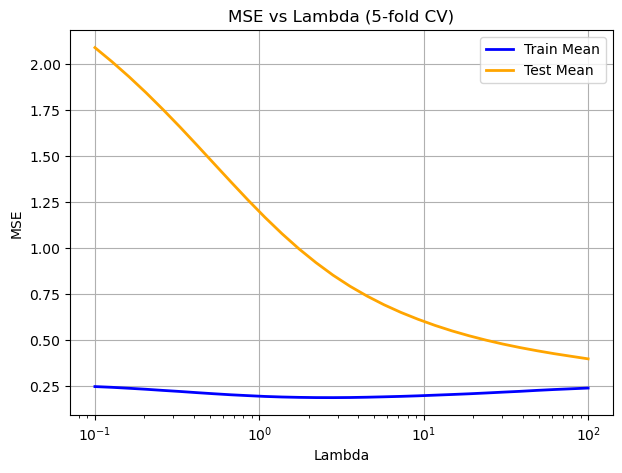

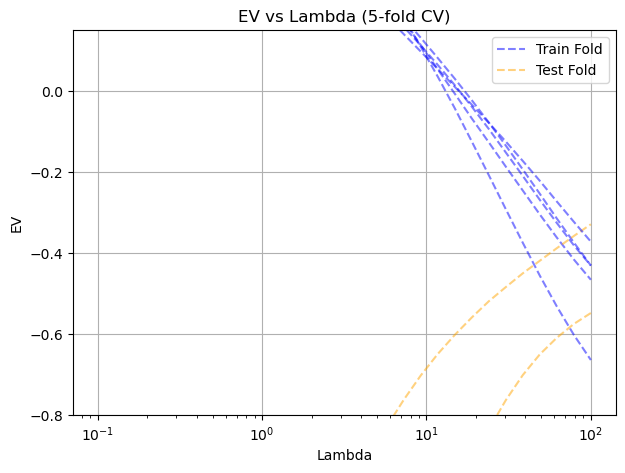

In [287]:
# Define the number of folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)
lambda_values = np.logspace(-1, 2, 30)

# Initialize dictionaries to store MSE for each fold
MSE_train_all = {lmbda: [] for lmbda in lambda_values}
MSE_test_all = {lmbda: [] for lmbda in lambda_values}
EV_train_all = {lmbda: [] for lmbda in lambda_values}
EV_test_all = {lmbda: [] for lmbda in lambda_values}

# Perform K-Fold cross-validation
for train_index, test_index in kf.split(N):
    N_train, N_test = N[train_index], N[test_index]
    alpha_train, alpha_test = alpha[train_index], alpha[test_index]

    for lambda1 in lambda_values:
        A = fourier_resolution(N_train, alpha_train, num_harmonics=5, lambda1=lambda1, normalization=50)
        R_train = N_train @ A
        R_test = N_test @ A

        # Compute MSE
        MSE_train, EV_train, c_train = performance_metrics(alpha_train, R_train)
        MSE_test, EV_test, c_test = performance_metrics(alpha_test, R_test)

        # Store per lambda & fold
        MSE_train_all[lambda1].append(MSE_train)
        MSE_test_all[lambda1].append(MSE_test)
        EV_train_all[lambda1].append(EV_train)
        EV_test_all[lambda1].append(EV_test)

all_EV_values = [(lmbda, max(EV_test_all[lmbda])) for lmbda in lambda_values]
MSE_test_mean = [np.mean(MSE_test_all[lmbda]) for lmbda in lambda_values]
#best_lambda = round(lambda_values[np.argmin(MSE_test_mean)], 1)
best_lambda, max_EV = max(all_EV_values, key=lambda x: x[1])
print("Best lambda:", best_lambda, "at max EV :", max_EV)

plot_CV_results(lambda_values, MSE_train_all, MSE_test_all, metrics="MSE", plot_mean=True)
plot_CV_results(lambda_values, EV_train_all, EV_test_all, metrics="EV", plot_mean=False, ylim=(-0.8, 0.15))

#### Train model for best lambda and evaluate performances

In [288]:
# Define the number of folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)
print("Train for lambda =", best_lambda)

# Perform K-Fold cross-validation
for train_index, test_index in kf.split(N):
    N_train, N_test = N[train_index], N[test_index]
    print(N_train.shape, N_test.shape)
    alpha_train, alpha_test = alpha[train_index], alpha[test_index]
 
    # Solve the model with current lambda1
    A = fourier_resolution(N_train, alpha_train, num_harmonics=3, lambda1=best_lambda, normalization=50)
    print("Nb of inactive tfs :", len(np.where((A.max(axis=1) - A.min(axis=1)) == 0)[0]))

    # Reconstructed rates = N * A
    R_train = N_train @ A
    R_test = N_test @ A  # Predict rates for test set

    # Compute explained variance & correlation coefficient
    MSE_train, EV_train, c_train = performance_metrics(alpha_train, R_train)
    MSE_test, EV_test, c_test = performance_metrics(alpha_test, R_test)
    print("Train MSE:", MSE_train, "Train EV:", EV_train, "Train c:", c_train)
    print("Test MSE:", MSE_test, "Test EV:", EV_test, "Test c:", c_test, "\n")

Train for lambda = 100.0
(124, 313) (32, 313)
Nb of inactive tfs : 18
Train MSE: 0.261 Train EV: -0.431 Train c: 0.304
Test MSE: 0.357 Test EV: -2.888 Test c: -0.118 

(125, 313) (31, 313)
Nb of inactive tfs : 6
Train MSE: 0.237 Train EV: -0.431 Train c: 0.276
Test MSE: 0.227 Test EV: -0.547 Test c: 0.052 

(125, 313) (31, 313)
Nb of inactive tfs : 12
Train MSE: 0.266 Train EV: -0.466 Train c: 0.241
Test MSE: 0.304 Test EV: -2.736 Test c: 0.21 

(125, 313) (31, 313)
Nb of inactive tfs : 6
Train MSE: 0.168 Train EV: -0.665 Train c: 0.222
Test MSE: 0.452 Test EV: -0.329 Test c: 0.039 

(125, 313) (31, 313)
Nb of inactive tfs : 20
Train MSE: 0.262 Train EV: -0.373 Train c: 0.326
Test MSE: 0.647 Test EV: -7.057 Test c: -0.11 



Train


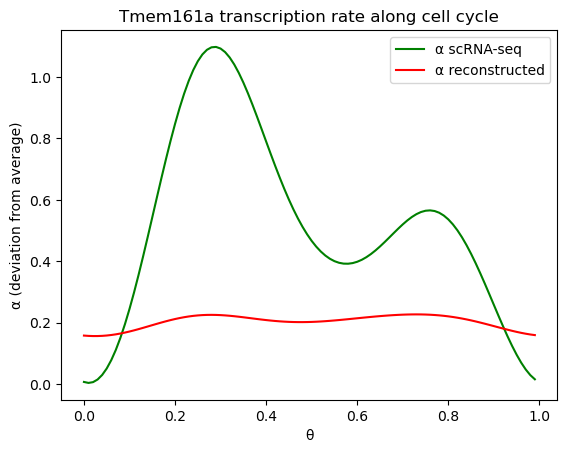

Test


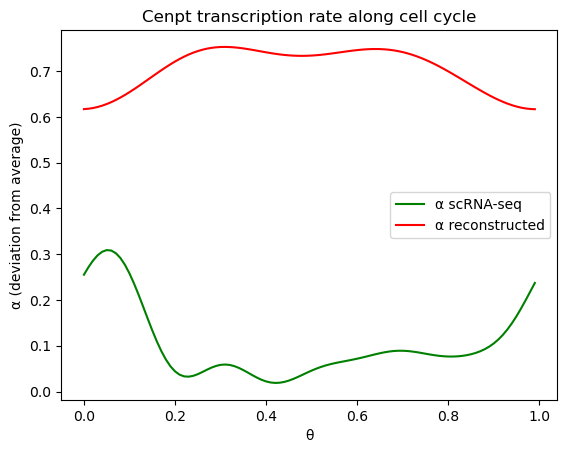

In [289]:
n = 10
print("Train")
plot_rate_comparison(targetnames_filtered[train_index], alpha_train, R_train, process, theta, target_nb=n)
print("Test")
plot_rate_comparison(targetnames_filtered[test_index], alpha_test, R_test, process, theta, target_nb=n)

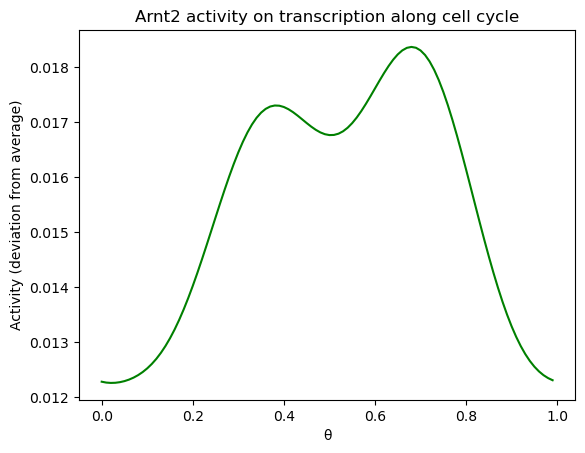

In [290]:
plot_binding_protein_activity(tf_names, A, process, theta, BP_nb=6)

In [291]:
%%!

UsageError: %%! is a cell magic, but the cell body is empty.


### Appendix

#### Fit Linear Model (lambda=1)

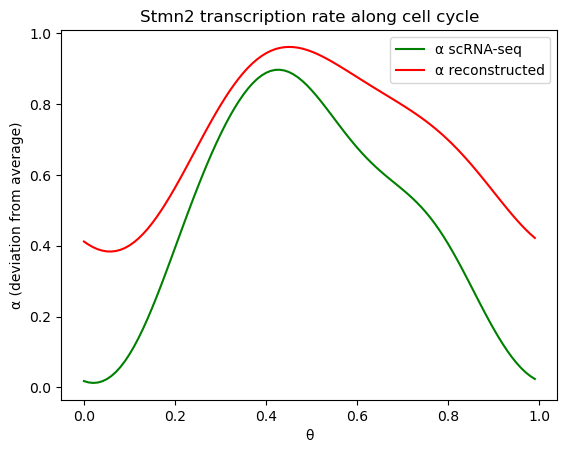

0.4027677229570401 0.8791975321033623


In [ ]:
# SOLVING THE LINEAR MODEL (X the activities in FS, A in NS)
lambda_value = 1
A = fourier_resolution(N, alpha, num_harmonics=2, lambda1=lambda_value)

# Reconstructed rates = N*A
R = N @ A
plot_rate_comparison(targetnames_filtered, alpha, R, process, theta, target_nb=1)
'''
L1 = np.sum((alpha - R) ** 2)  # Sum of squared errors

# Compute the second term: Regularization term
L2 = np.sum(A ** 2)  # Sum of squared A values
L2 = lambda_value * L2  # Apply lambda scaling
print(L1, L2)
'''
# Compute explained variance & corr coeff
_, EV, c = performance_metrics(alpha, R)
print(EV,c)

#### Scikit-learn dataset split (Original code)

In [ ]:
# Define lambda range
lambda_values = np.logspace(-2, 6, 30)  # From 1e-3 to 1e3
results = []

# Split indices into training and testing sets (80% train, 20% test)
train_idx, test_idx = train_test_split(np.arange(N.shape[0]), test_size=0.2, random_state=42)

# Use the indices to split N and alpha
N_train, N_test = N[train_idx], N[test_idx]
alpha_train, alpha_test = alpha[train_idx], alpha[test_idx]

print(f"Train: {N_train.shape[0]}, Test: {N_test.shape[0]}")

# Grid search over lambda values
for lambda1 in lambda_values:
    # Solve the model with current lambda1
    A = fourier_resolution(N_train, alpha_train, num_harmonics=3, lambda1=lambda1, normalization=50)

    # Reconstructed rates = N * A
    R_train = N_train @ A
    R_test = N_test @ A  # Predict rates for test set

    # Compute explained variance & correlation coefficient
    MSE_train, EV_train, c_train = performance_metrics(alpha_train, R_train)
    MSE_test, EV_test, c_test = performance_metrics(alpha_test, R_test)

    results.append((lambda1, EV_train, EV_test, MSE_train, MSE_test))

# Convert results to numpy array for easy sorting
results = np.array(results)

Train: 132, Test: 33


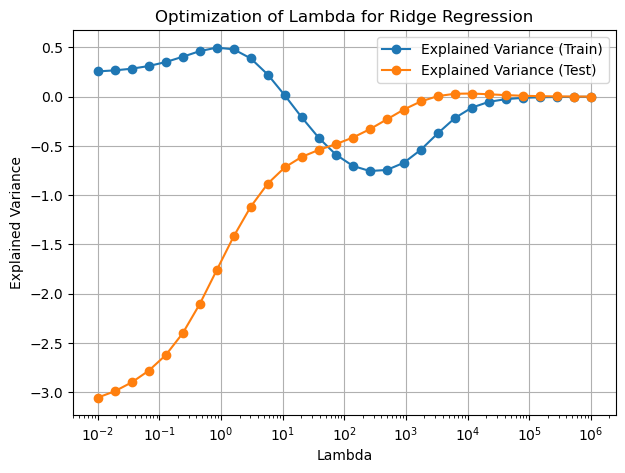

Best lambda value: 11721.02
Best EV (Test): 0.0321


In [ ]:
plt.figure(figsize=(7,5))
plt.plot(results[:,0], results[:,1], marker='o', label="Explained Variance (Train)")
plt.plot(results[:,0], results[:,2], marker='o', label="Explained Variance (Test)")
plt.xscale("log")
plt.xlabel("Lambda")
plt.ylabel("Explained Variance")
#plt.ylim(-0.8, 0.1)
plt.title("Optimization of Lambda for Ridge Regression")
plt.legend()
plt.grid()
plt.show()
print("Best lambda value:", round(results[np.argmax(results[:,2]), 0],2))
print("Best EV (Test):", round(results[np.argmax(results[:,2]), 2],4))

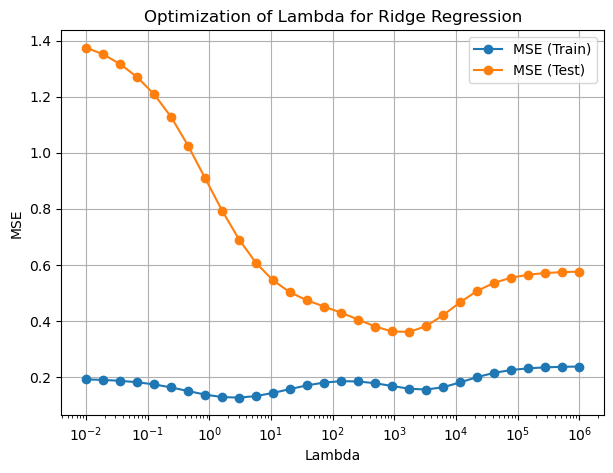

Best lambda value: 1743.33
Best MSE on test set: 0.36


In [ ]:
plt.figure(figsize=(7,5))
plt.plot(results[:,0], results[:,3], marker='o', label="MSE (Train)")
plt.plot(results[:,0], results[:,4], marker='o', label="MSE (Test)")
plt.xscale("log")
plt.xlabel("Lambda")
plt.ylabel("MSE")
#plt.ylim(-0.8, 0.1)
plt.title("Optimization of Lambda for Ridge Regression")
plt.legend()
plt.grid()
plt.show()
print("Best lambda value:", round(results[np.argmin(results[:,4]), 0], 2))
print("Best MSE on test set:", round(results[np.argmin(results[:,4]), 4], 2))

##### Minimizing the loss function.

In [ ]:
# Define lambda range
lambda_values = np.logspace(-3, 6, 25)  # From 1e-1 to 1e2
#lambda_values = [1]
results = []

# Split data into training and testing sets (80% train, 20% test)
N_train, N_test, alpha_train, alpha_test = train_test_split(N, alpha, test_size=0.2, random_state=42)
print("Train : ", alpha_train.shape[0], "Test : ", alpha_test.shape[0])

# Grid search over lambda values
for lambda1 in lambda_values:
    # Solve the model with current lambda1
    A = fourier_resolution(N_train, alpha_train, num_harmonics=10, lambda1=lambda1, normalization=50)

    # Reconstructed rates = N*A
    R_train = N_train @ A
    # Predict rates for test set
    R_test = N_test @ A

    L1_train = np.sum((alpha_train - R_train) ** 2)  # Sum of squared errors
    L1_test = np.sum((alpha_test - R_test) ** 2)  # Sum of squared errors

    # Compute the second term: Regularization term
    L2 = np.sum(A ** 2)  # Sum of squared A values
    L2 = lambda1 * L2  # Apply lambda scaling

    loss_train = L1_train + L2
    loss_test = L1_test + L2

    results.append((lambda1, loss_train, loss_test))

# Convert results to numpy array for easy sorting
results = np.array(results)

Train :  132 Test :  33


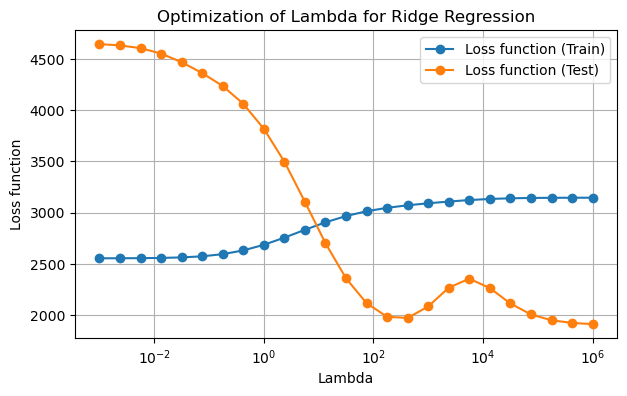

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(results[:,0], results[:,1], marker='o', label="Loss function (Train)")
plt.plot(results[:,0], results[:,2], marker='o', label="Loss function (Test)")
plt.xscale("log")
plt.xlabel("Lambda")
plt.ylabel("Loss function")
plt.title("Optimization of Lambda for Ridge Regression")
plt.legend()
plt.grid()
plt.show()

##### Vizualize EV per gene

In [ ]:
# Define lambda range
lambda_values = np.logspace(-2, 2, 25)  # From 1e-1 to 1e2
EVs_train = []
EVs_test = []

# Split data into training and testing sets (80% train, 20% test)
N_train, N_test, alpha_train, alpha_test = train_test_split(N, alpha, test_size=0.2, random_state=42)
print("Train : ", alpha_train.shape[0], "Test : ", alpha_test.shape[0])

# Grid search over lambda values
for lambda1 in lambda_values:
    # Solve the model with current lambda1
    A = fourier_resolution(N_train, alpha_train, num_harmonics=2, lambda1=lambda1, normalization=50)

    # Reconstructed rates = N*A
    R_train = N_train @ A
    # Predict rates for test set
    R_test = N_test @ A

    # Compute explained variance & corr coeff
    EV_train = 1 - np.var(R_train - alpha_train, axis=1) / np.var(alpha_train, axis=1) #Explained variance for each train gene
    EV_test = 1 - np.var(R_test - alpha_test, axis=1) / np.var(alpha_test, axis=1) #Explained variance for each test gene

    EVs_train.append(EV_train)
    EVs_test.append(EV_test)

EVs_train, EVs_test = np.array(EVs_train), np.array(EVs_test)

Train :  132 Test :  33


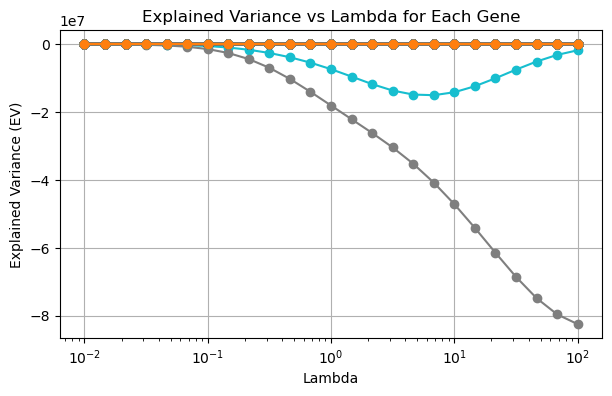

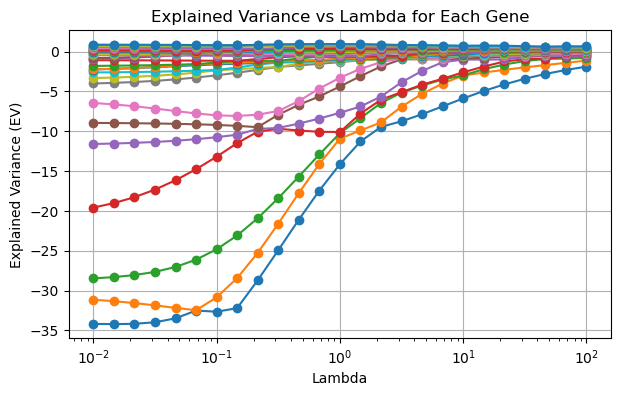

In [ ]:
def plot_genes_EV(EV):
    # Number of genes (you can adjust this based on the actual shape of EV_test)
    num_genes = EV.shape[1]  # Assuming EV_test is of shape (num_lambdas, num_genes)

    # Plot EV_test for each gene as a function of lambda
    plt.figure(figsize=(7,5))

    for gene_idx in range(num_genes):
        # Extract the EV_test values for the current gene (i.e., all lambdas for this gene)
        EV_gene = EV[:, gene_idx]
        
        # Plot EV vs lambda for the current gene
        plt.plot(lambda_values, EV_gene, marker='o')

    # Add labels, legend, and title
    plt.xscale('log')  # Log scale for lambda axis
    plt.xlabel('Lambda')
    plt.ylabel('Explained Variance (EV)')
    plt.title('Explained Variance vs Lambda for Each Gene')
    plt.grid(True)
    plt.show()
EVs_test = np.sort(EVs_test)
plot_genes_EV(EVs_train)
plot_genes_EV(EVs_test[:, 2:])

In [ ]:
%%!

UsageError: %%! is a cell magic, but the cell body is empty.


#### Ridge

In [ ]:
# Split data into training and testing sets (80% train, 20% test)
N_train, N_test, alpha_train, alpha_test = train_test_split(N, alpha, test_size=0.2, random_state=42)
'''
# Define lambda range for Ridge
lambda_values = np.logspace(-3, 3, 20)

# Perform Grid Search with Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
ridge = Ridge(fit_intercept=False)

grid = GridSearchCV(ridge, param_grid={'alpha': lambda_values}, cv=kf, scoring='r2')  # Use R² as the metric, or explained_variance or neg_root_mean_squared_error (ISMARA)
grid.fit(N, alpha)  # Train on full dataset with CV

best_lambda = grid.best_params_['alpha']
print(f"Best lambda found: {best_lambda}")
'''
# Train final model using best lambda
ridge = Ridge(alpha=1)

F = (fourier_basis(theta, num_harmonics=5).T)/np.sqrt(50)

alpha_hat_train = alpha_train @ F

ridge.fit(N_train, alpha_hat_train)  # Solves for X

R_test = ridge.predict(N_test)
R_test = R_test @F.T #FS to NS

# Compute final performance
EV, c = performance_metrics(alpha_test, R_test)
print(f"Final model performance: EV={EV:.3f}, c={c:.3f}")


Final model performance: EV=-0.926, c=0.015


##### RidgeCV

In [ ]:
# Define lambda range
lambda_values = np.logspace(0, 6, 50)  # From 1e-3 to 1e3
results = []

# Split indices into training and testing sets (80% train, 20% test)
train_idx, test_idx = train_test_split(np.arange(N.shape[0]), test_size=0.2, random_state=42)

# Use the indices to split N and alpha
N_train, N_test = N[train_idx], N[test_idx]
alpha_train, alpha_test = alpha[train_idx], alpha[test_idx]

# Initialize RidgeCV with cross-validation
ridge_model = RidgeCV(alphas=lambda_values, cv=5)

ridge_model.fit(N_train, alpha_train)
# Print the best alpha found by RidgeCV
print(f"Best alpha: {ridge_model.alpha_}")

R_test = ridge_model.predict(N_test)
print("EV test : ", explained_variance_score(alpha_test, R_test))

# Evaluate the model on the test set
test_score = ridge_model.score(N_test, alpha_test)
print(f"Test score (R^2): {test_score}")

Best alpha: 1151.395399326447
EV test :  -0.02617931958911165
Test score (R^2): -0.07685585611279089


#### Data Vizualization (plotting)

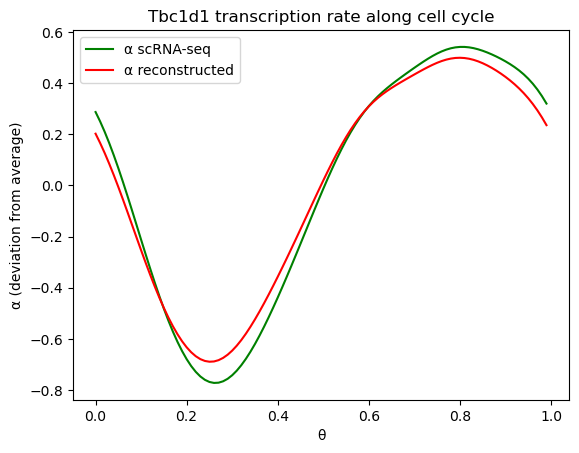

In [ ]:
#Compare actual rates with reconstructed
plot_rate_comparison(genenames_filtered, alpha, R, process, theta, target_nb= 9)

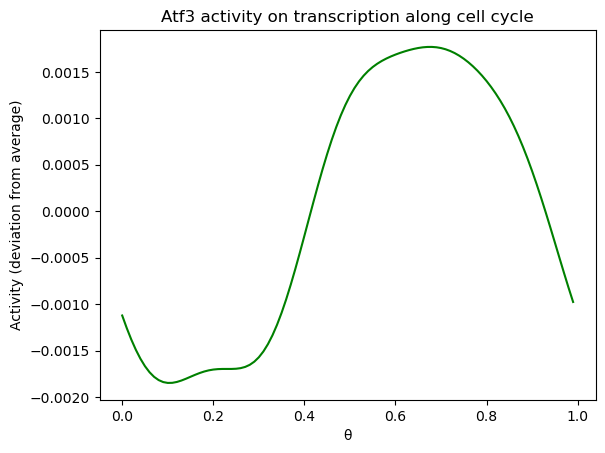

In [ ]:
#Activity of the transcription factor
plot_binding_protein_activity(tf_names, A, BP_nb = 10)

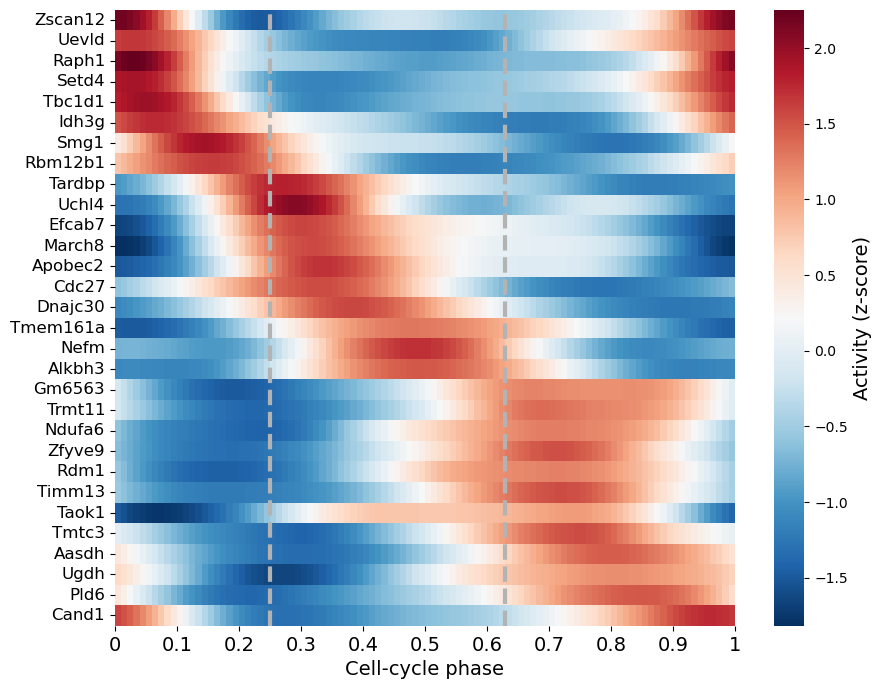

In [ ]:
#Heatmap of targets activity (expression, splicing, export, degradation) along cell cycle
plot_heatmap(alpha, ylabels=genenames_filtered, display_limit=30)

In [ ]:
#We keep only the BPs that regulates retained targets.
total_binding_sites = N.sum(axis=0) #Each column (=BP) now contains the total number of binding sites across all targets (sum along the rows)
A = A[total_binding_sites > 0, :]
tf_names = tf_names[total_binding_sites > 0]
#Number of active motif that regulates retained targets
print("Kept TFs :", np.sum(total_binding_sites > 0))

Kept TFs : 153


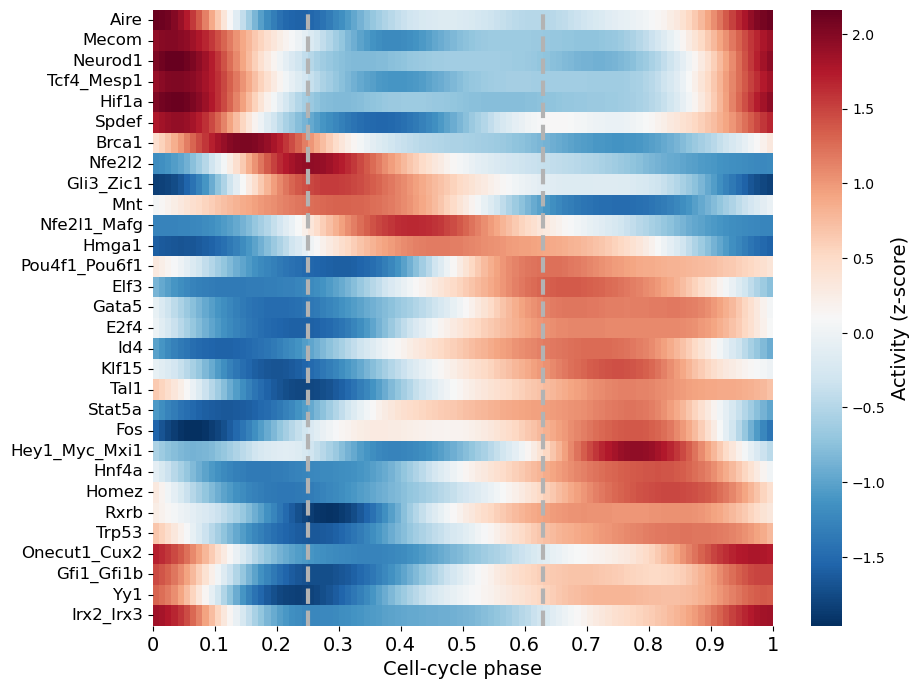

In [ ]:
#Heatmap of BPs activity along cell cycle
plot_heatmap(A, ylabels=tf_names, display_limit=30)

In [ ]:
%%!

UsageError: %%! is a cell magic, but the cell body is empty.


### Splicing

### Export

In [ ]:
#Import files containing the binding sites and the process rates for each target.
fileBSM = 'FurierCycleResults/ENCORI_mm10_RBPTarget_matrix.txt' # text file with the binding sites matrix that infrom the interactions BP -> Target
fileEta = 'FurierCycleResults/bootstrap_eta_snrna_rep1_100_1_1.csv'
#Defining the process (name, greek letter)
process = ["export", "\u03B7"]

In [ ]:
# Reading binding site matrix and targets' rates
N = pd.read_csv(fileBSM, sep="\t",index_col=0)
N = N.drop(N.columns[-1], axis=1)
eta = pd.read_csv(fileEta, sep=",",index_col=0)
theta = np.arange(0, 1, 0.01)

In [ ]:
# PREPROCESSING
# Select targets for which we know binding sites for BPs
RBP_names = N.columns
print("Initial RNAs :", eta.shape[0])
eta, N, RNAnames_filtered = preprocessing(N, eta, threshold=2)

#Number of retained RNAs
print("Kept RNAs :", eta.shape[0])

Initial RNAs : 115820
Kept RNAs : 491


In [ ]:
# Define lambda range
lambda_values = np.logspace(-2, 2, 25)  # From 1e-1 to 1e2
#lambda_values = [1]
results = []

# Split data into training and testing sets (80% train, 20% test)
N_train, N_test, eta_train, eta_test = train_test_split(N, eta, test_size=0.2, random_state=42)
print("Train : ", eta_train.shape[0], "Test : ", eta_test.shape[0])

# Grid search over lambda values
for lambda1 in lambda_values:
    # Solve the model with current lambda1
    A = fourier_resolution(N_train, eta_train, num_harmonics=5, lambda1=lambda1, normalization=50)

    # Reconstructed rates = N*A
    R_train = N_train @ A
    # Predict rates for test set
    R_test = N_test @ A

    # Compute explained variance & corr coeff
    EV_train, c_train = performance_metrics(eta_train, R_train)
    EV_test, c_test = performance_metrics(eta_test, R_test)

    results.append((lambda1, EV_train, c_train, EV_test, c_test))

# Convert results to numpy array for easy sorting
results = np.array(results)

Train :  392 Test :  99


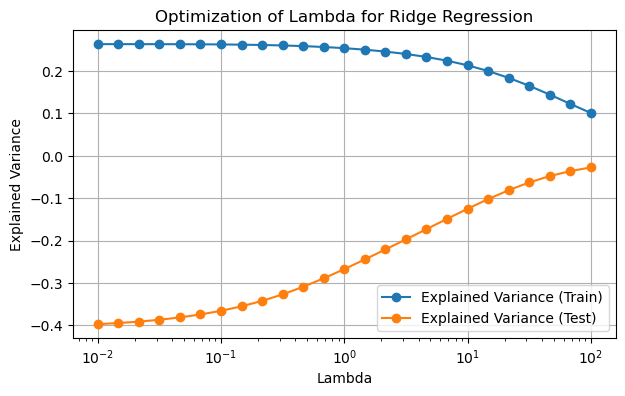

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(results[:,0], results[:,1], marker='o', label="Explained Variance (Train)")
plt.plot(results[:,0], results[:,3], marker='o', label="Explained Variance (Test)")
plt.xscale("log")
plt.xlabel("Lambda")
plt.ylabel("Explained Variance")
plt.title("Optimization of Lambda for Ridge Regression")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# SOLVING THE LINEAR MODEL (X the activities in FS, A in NS)
A = fourier_resolution(N, eta, num_harmonics=5)

# Reconstructed rates = N*A
R = N @ A

# Explained variance
EV = 1-np.var(R.flatten()-eta.flatten())/np.var(eta.flatten())
#Correlation coefficient
c = np.corrcoef(eta.flatten(),R.flatten())[0,1]
print(EV,c)

ValueError: too many values to unpack (expected 2)

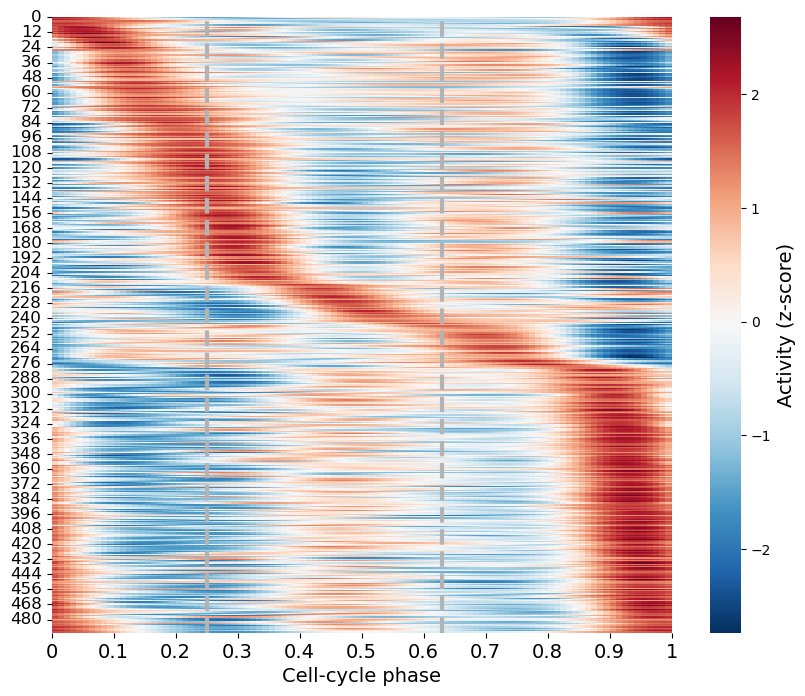

In [ ]:
#Heatmap of targets activity (expression, splicing, export, degradation) along cell cycle
plot_heatmap(eta, ylabels=None, display_limit=None)

In [ ]:
#We keep only the BPs that regulates retained targets.
total_binding_sites = N.sum(axis=0) #Each column (=BP) now contains the total number of binding sites across all targets (sum along the rows)
A = A[total_binding_sites > 0, :]
print("Initial RBPs :", RBP_names.shape[0])
RBP_names = RBP_names[total_binding_sites > 0]
#Number of active motif that regulates retained targets
print("Kept RBPs :", np.sum(total_binding_sites > 0))

Initial RBPs : 95
Kept RBPs : 51


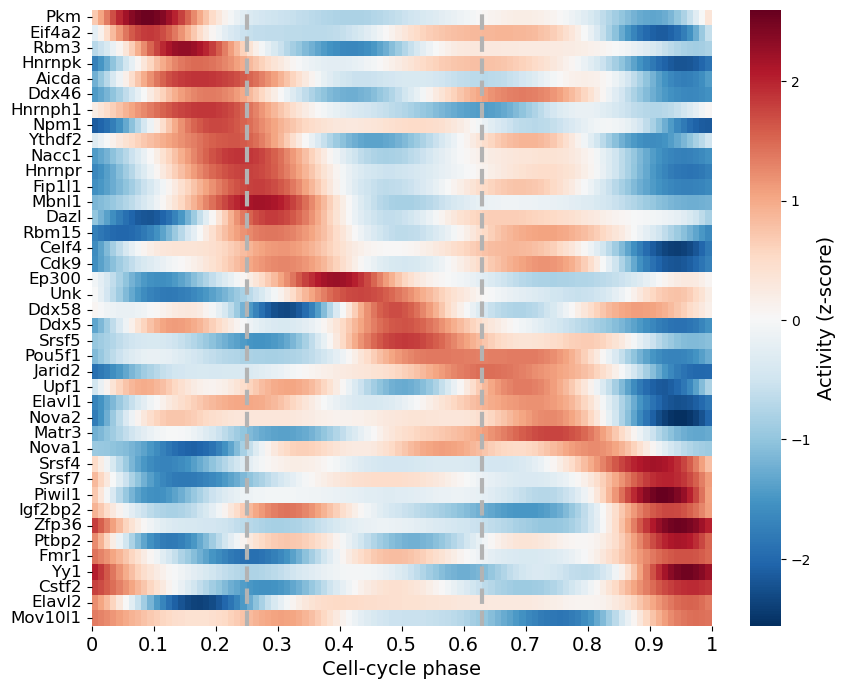

In [ ]:
#Heatmap of BPs activity along cell cycle
plot_heatmap(A, ylabels=RBP_names, display_limit=40)

### Degradation

In [ ]:
#Import files containing the binding sites and the process rates for each target.
fileBSM = 'FurierCycleResults/ENCORI_mm10_RBPTarget_matrix.txt' # text file with the binding sites matrix that infrom the interactions BP -> Target
fileGamma = 'FurierCycleResults/bootstrap_gamma_scrna_100_1_1.csv'
#Defining the process (name, greek letter)
process = ["degradation", "\u03B3"]

In [ ]:
# Reading binding site matrix and targets' rates
N = pd.read_csv(fileBSM, sep="\t",index_col=0)
N = N.drop(N.columns[-1], axis=1)
gamma = pd.read_csv(fileGamma, sep=",",index_col=0)
theta = np.arange(0, 1, 0.01)


NameError: name 'pd' is not defined

In [ ]:
# PREPROCESSING
# Select targets for which we know binding sites for BPs
RBP_names = N.columns
print("Initial RNAs :", gamma.shape[0])
gamma, N, RNAnames_filtered = preprocessing(N, gamma, threshold=1.5)

#Number of retained RNAs
print("Kept RNAs :", gamma.shape[0])

Initial RNAs : 122380
Kept RNAs : 336


In [ ]:
# SOLVING THE LINEAR MODEL (X the activities in FS, A in NS)
A = fourier_resolution(N, gamma, num_harmonics=5)

# Reconstructed rates = N*A
R = N @ A

# Explained variance
EV = 1-np.var(R.flatten()-gamma.flatten())/np.var(gamma.flatten())
#Correlation coefficient
c = np.corrcoef(gamma.flatten(),R.flatten())[0,1]
print(EV,c)

0.2746541585255844 0.5254622490067528


In [ ]:
# Define lambda range
lambda_values = np.logspace(-2, 2, 25)  # From 1e-1 to 1e2
#lambda_values = [1]
results = []

# Split data into training and testing sets (80% train, 20% test)
N_train, N_test, gamma_train, gamma_test = train_test_split(N, gamma, test_size=0.2, random_state=42)
print("Train : ", gamma_train.shape[0], "Test : ", gamma_test.shape[0])

# Grid search over lambda values
for lambda1 in lambda_values:
    # Solve the model with current lambda1
    A = fourier_resolution(N_train, gamma_train, num_harmonics=5, lambda1=lambda1, normalization=50)

    # Reconstructed rates = N*A
    R_train = N_train @ A
    # Predict rates for test set
    R_test = N_test @ A

    # Compute explained variance & corr coeff
    EV_train, c_train = performance_metrics(gamma_train, R_train)
    EV_test, c_test = performance_metrics(gamma_test, R_test)

    results.append((lambda1, EV_train, c_train, EV_test, c_test))

# Convert results to numpy array for easy sorting
results = np.array(results)

Train :  268 Test :  68


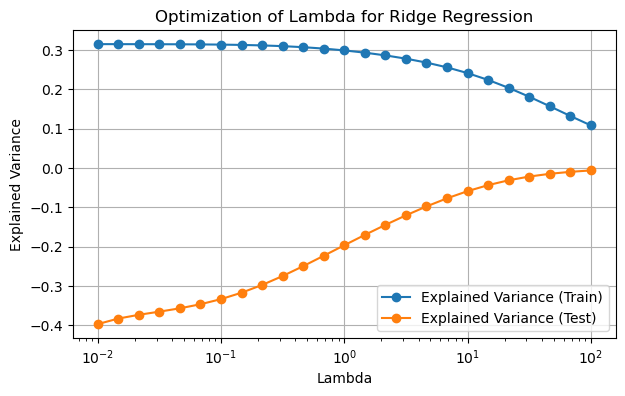

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(results[:,0], results[:,1], marker='o', label="Explained Variance (Train)")
plt.plot(results[:,0], results[:,3], marker='o', label="Explained Variance (Test)")
plt.xscale("log")
plt.xlabel("Lambda")
plt.ylabel("Explained Variance")
plt.title("Optimization of Lambda for Ridge Regression")
plt.legend()
plt.grid()
plt.show()

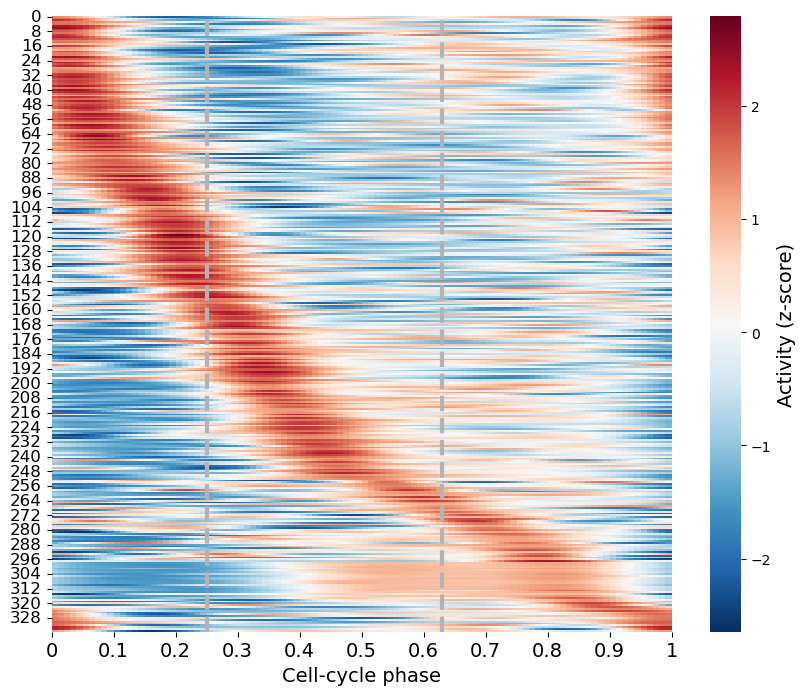

In [ ]:
#Heatmap of targets activity (expression, splicing, export, degradation) along cell cycle
plot_heatmap(gamma, ylabels=None, display_limit=None)

In [ ]:
#We keep only the BPs that regulates retained targets.
total_binding_sites = N.sum(axis=0) #Each column (=BP) now contains the total number of binding sites across all targets (sum along the rows)
A = A[total_binding_sites > 0, :]
print("Initial RBPs :", RBP_names.shape[0])
RBP_names = RBP_names[total_binding_sites > 0]
#Number of active motif that regulates retained targets
print("Kept RBPs :", np.sum(total_binding_sites > 0))

Initial RBPs : 95
Kept RBPs : 55


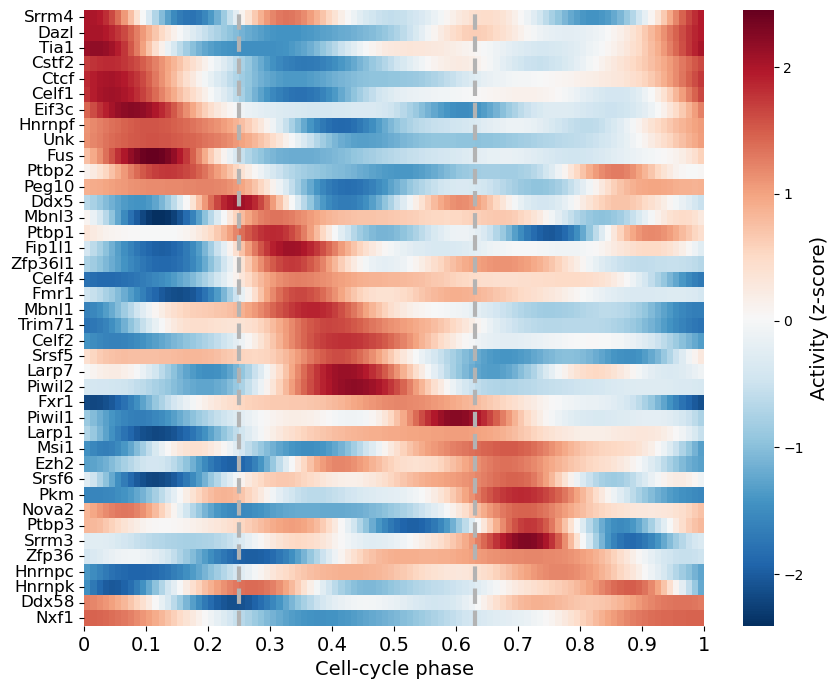

In [ ]:
#Heatmap of BPs activity along cell cycle
plot_heatmap(A, ylabels=RBP_names, display_limit=40)